In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# Creating the Model

In [4]:
# Start and end time (in milliseconds)
t0 = 0
t1 = 100
t = np.linspace(t0, t1, 100000)

# Membrane capacitance (uF/cm^2)
C = 1.0

# Potassium potential (mV)
VK = -10

# Sodium potential (mV)
VNa = 110

# Leak potential (mV)
Vl = 10.0

# Potassium channel conductance (mS/cm^2)
gK = 4.0

# Sodium channel conductance (mS/cm^2)
gNa = 4.0

# Leak channel conductance (mS/cm^2)
gL = 1.0

# Rate functions as defined in model
def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp((10.0 - Vm) / 10.0) - 1.0)

def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)

def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp((25.0 - Vm) / 10) - 1.0)

def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)

def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)

def beta_h(Vm):
    return 1.0 / (np.exp((30 - Vm) / 10) + 1.0)

# Now define the n, m, and h's long term behvious as described in the model
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))

# In the differential equations defined, external stimulus is not depicted
# we encode it as a current density in the input signal.
# Single square pulse implimentation 
def I(t):
    if 0.0 < t < 1.0:
        return 100.0
    return 0.0
    # return 100.0 * np.exp(-np.power(t - 50.0, 2.0) / (2.0 * np.power(5.0, 2.0)))
    
def derivatives(y, t0):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]

    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)

    # dVm/dt
    dy[0] = (I(t0) / C) - (((gK / C) * np.power(n, 4.0)) 
                        * (Vm - VK)) - (((gNa / C) * np.power(m, 3.0) * h) 
                        * (Vm - VNa)) - ((gL / C) * (Vm - Vl))
    
    return dy

# Solve ODE system
state = np.array([0.0, n_inf(), m_inf(), h_inf()])
results = odeint(derivatives, state, t)

# Initial Plot with Single Square Pulse

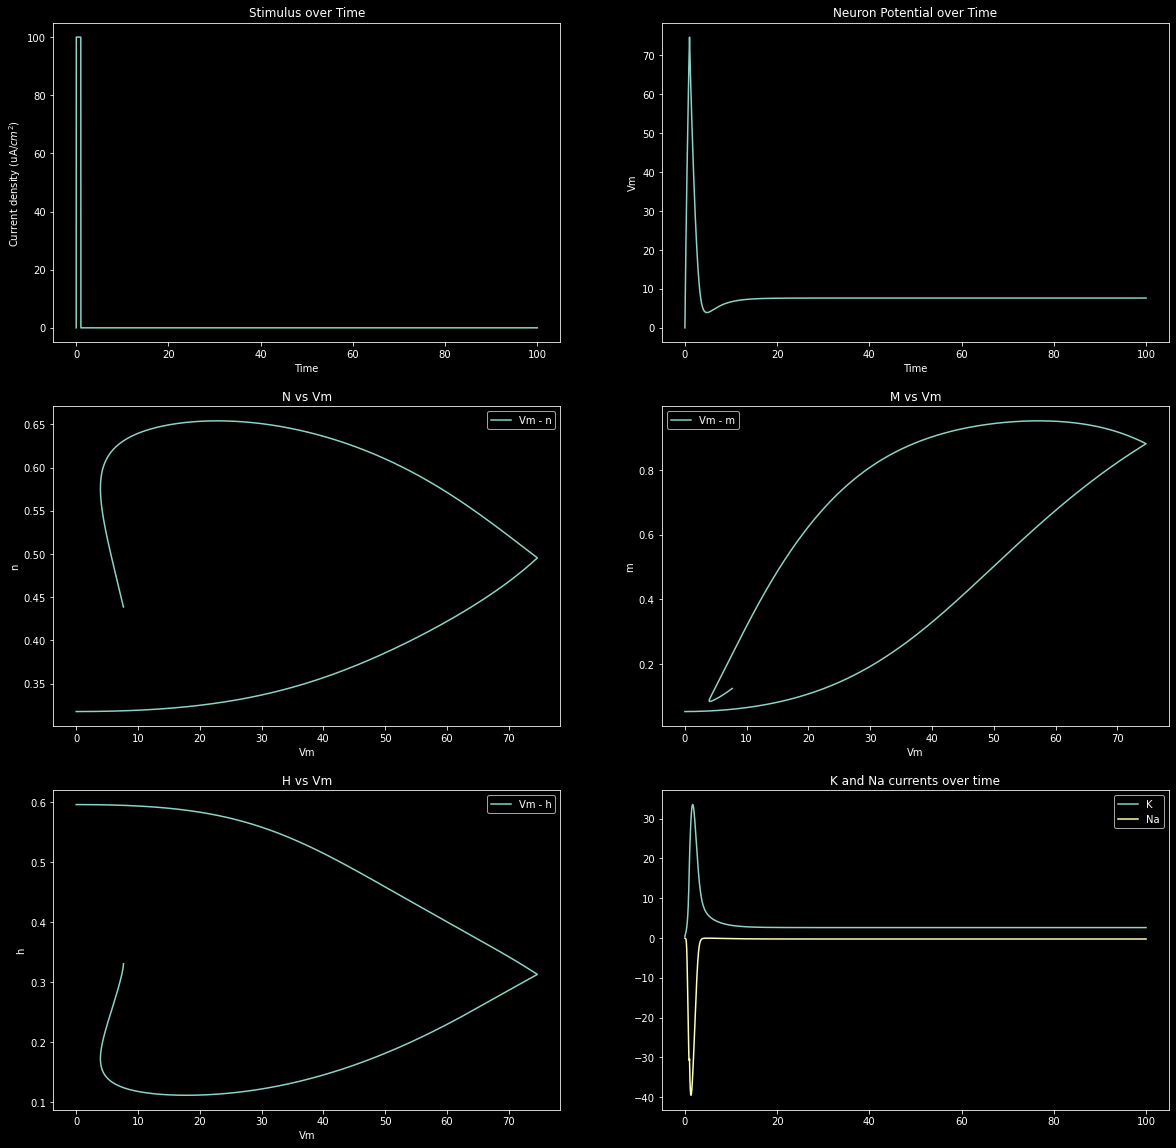

In [5]:
# Input stimulus
Idv = [I(t) for t in t]

# Plot neuron potential over time
fig, ax = plt.subplots(3,2,figsize=(20, 20))
ax = ax.reshape(-1)
ax[1].plot(t, results[:, 0])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Vm')
ax[1].set_title('Neuron Potential over Time')
# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

# Plot some trajectories
ax[2].plot(results[:, 0], results[:, 1], label='Vm - n')
ax[3].plot(results[:, 0], results[:, 2], label='Vm - m')
ax[4].plot(results[:, 0], results[:, 3], label='Vm - h')
ax[2].set_title('N vs Vm')
ax[2].set_xlabel('Vm')
ax[2].set_ylabel('n')
ax[2].legend()
ax[3].set_title('M vs Vm')
ax[3].set_xlabel('Vm')
ax[3].set_ylabel('m')
ax[3].legend()
ax[4].set_title('H vs Vm')
ax[4].set_xlabel('Vm')
ax[4].set_ylabel('h')
ax[4].legend()

# plot Ik and Ina over time
ax[5].plot(t, gK * np.power(results[:, 1], 4.0) * (results[:, 0] - VK), label='K')
ax[5].plot(t, gNa * np.power(results[:, 2], 3.0) * results[:, 3] * (results[:, 0] - VNa), label='Na')
# ax[5].plot(t, gL * (results[:, 0] - Vl), label='L') ## LEAK CURRENT PLOT
ax[5].set_title('K and Na currents over time')
ax[5].legend()

### Plotting activations parameters

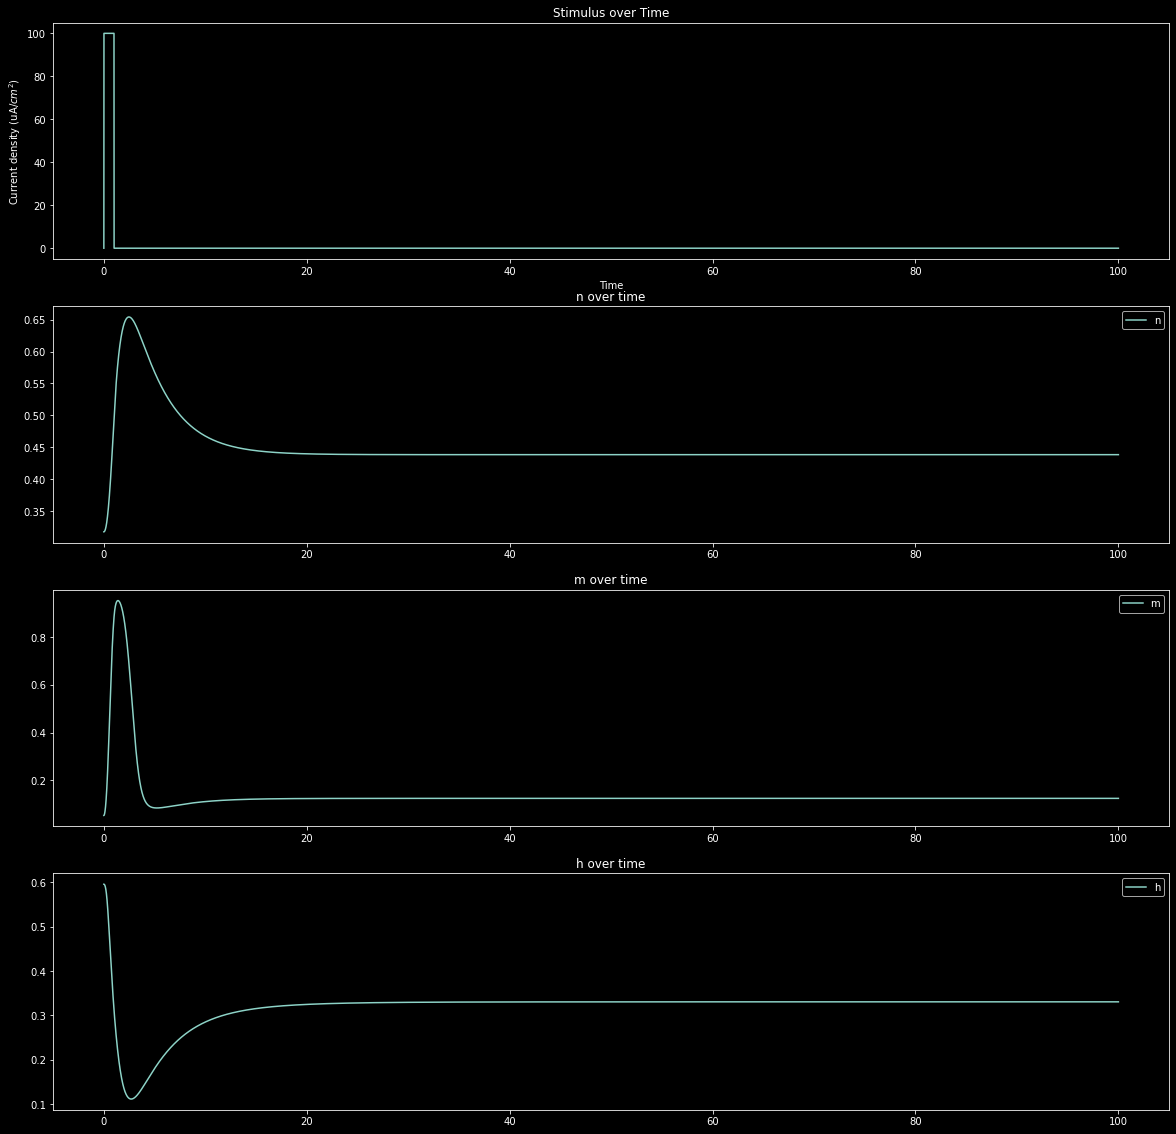

In [6]:
# Now plot n, m, and h over time
fig, ax = plt.subplots(4,1,figsize=(20, 20))

# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

ax[1].plot(t, results[:, 1], label='n')
ax[2].plot(t, results[:, 2], label='m')
ax[3].plot(t, results[:, 3], label='h')
ax[1].set_title('n over time')
ax[1].legend()
ax[2].set_title('m over time')
ax[2].legend()
ax[3].set_title('h over time')
ax[3].legend()

plt.show()

n, m, and h represent potassium and sodium chanel activations and inactivations. n is potassium activation probability, m is sodium activation probability, and h is sodium inactivation probability. 

# CHANGING PARAMETERS
## Changing input signal

### Double square pulse

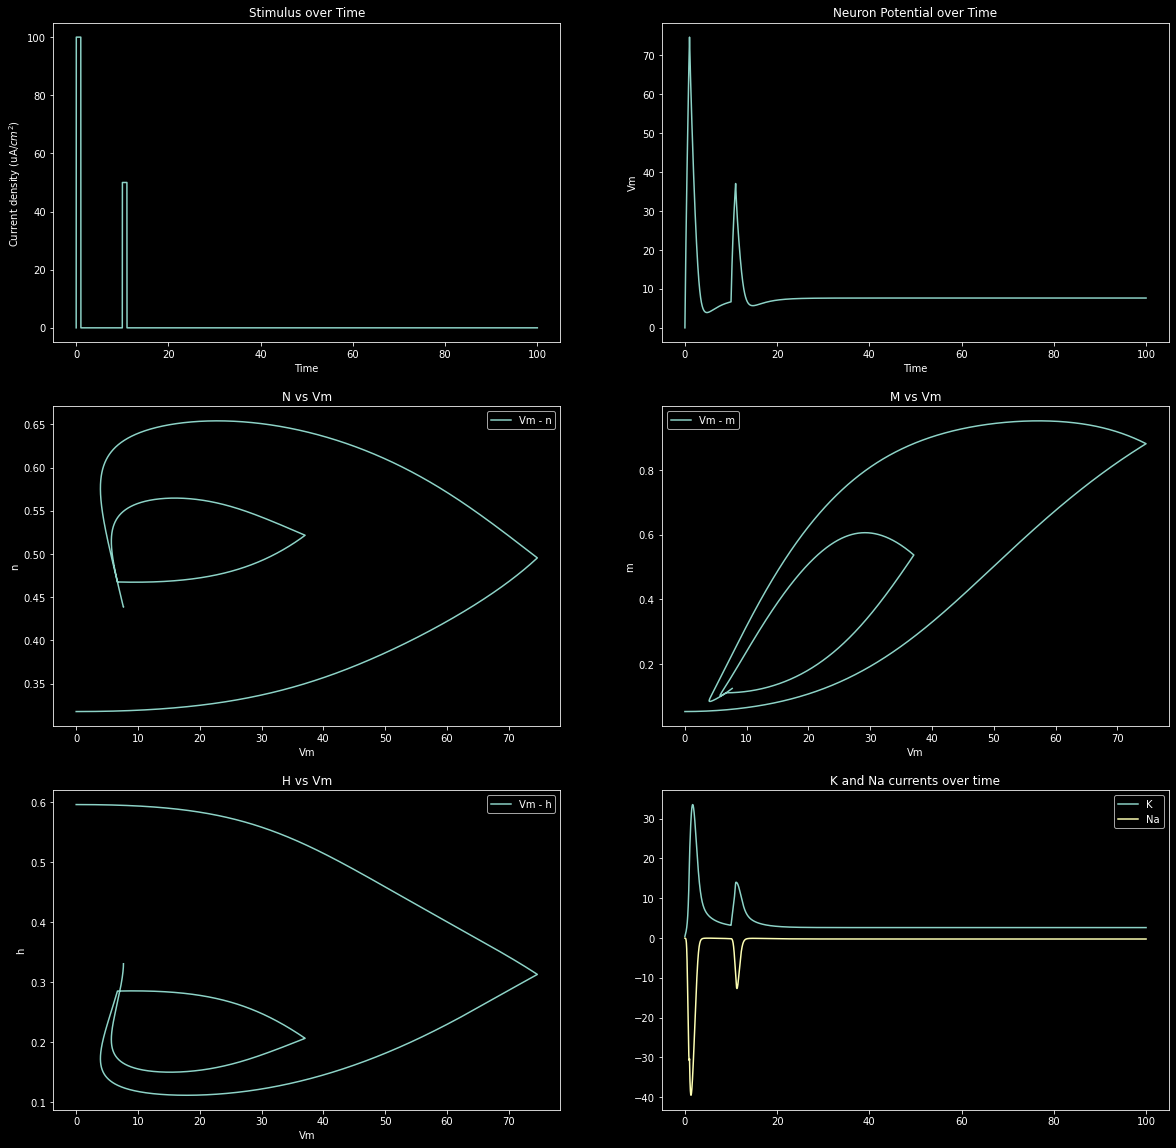

In [7]:
def I_double_square(t):
    if 0.0 < t < 1.0:
        return 100.0
    elif 10.0 < t < 11.0:
        return 50.0
    return 0.0

t0 = 0
t1 = 100
t = np.linspace(t0, t1, 100000)
    
def derivatives(y, t0):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]

    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)

    # dVm/dt
    dy[0] = (I_double_square(t0) / C) - (((gK / C) * np.power(n, 4.0)) 
                        * (Vm - VK)) - (((gNa / C) * np.power(m, 3.0) * h) 
                        * (Vm - VNa)) - ((gL / C) * (Vm - Vl))
    
    return dy

# Solve ODE system
state = np.array([0.0, n_inf(), m_inf(), h_inf()])
results = odeint(derivatives, state, t)

# Input stimulus
Idv = [I_double_square(t) for t in t]

# Plot neuron potential over time
fig, ax = plt.subplots(3,2,figsize=(20, 20))
ax = ax.reshape(-1)
ax[1].plot(t, results[:, 0])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Vm')
ax[1].set_title('Neuron Potential over Time')
# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

# Plot some trajectories
ax[2].plot(results[:, 0], results[:, 1], label='Vm - n')
ax[3].plot(results[:, 0], results[:, 2], label='Vm - m')
ax[4].plot(results[:, 0], results[:, 3], label='Vm - h')
ax[2].set_title('N vs Vm')
ax[2].set_xlabel('Vm')
ax[2].set_ylabel('n')
ax[2].legend()
ax[3].set_title('M vs Vm')
ax[3].set_xlabel('Vm')
ax[3].set_ylabel('m')
ax[3].legend()
ax[4].set_title('H vs Vm')
ax[4].set_xlabel('Vm')
ax[4].set_ylabel('h')
ax[4].legend()

# plot Ik and Ina over time
ax[5].plot(t, gK * np.power(results[:, 1], 4.0) * (results[:, 0] - VK), label='K')
ax[5].plot(t, gNa * np.power(results[:, 2], 3.0) * results[:, 3] * (results[:, 0] - VNa), label='Na')
# ax[5].plot(t, gL * (results[:, 0] - Vl), label='L') ## LEAK CURRENT PLOT
ax[5].set_title('K and Na currents over time')
ax[5].legend()

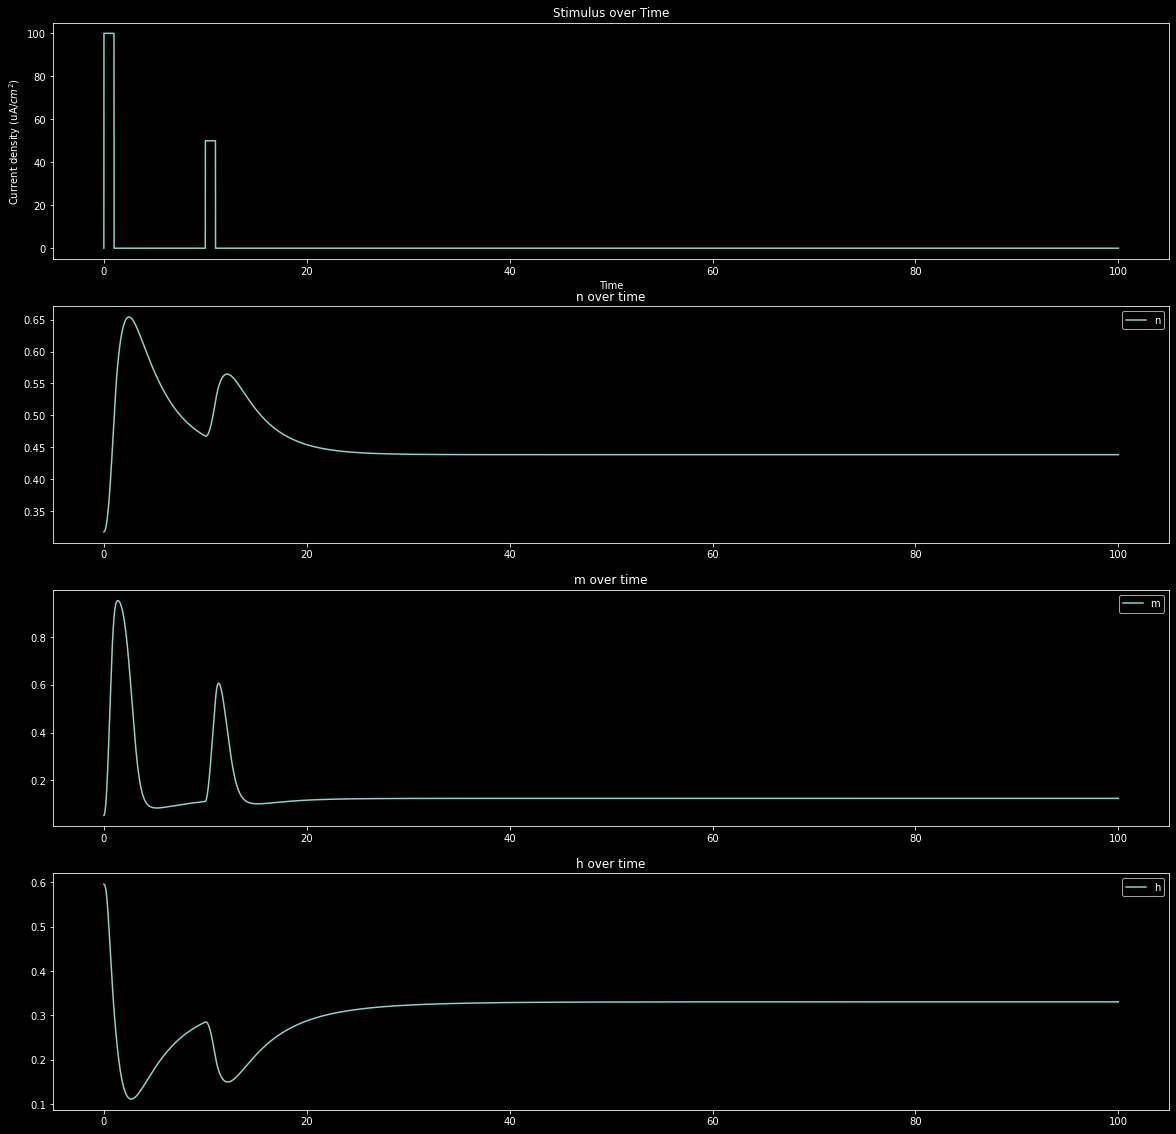

In [8]:
# Now plot n, m, and h over time
fig, ax = plt.subplots(4,1,figsize=(20, 20))

# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

ax[1].plot(t, results[:, 1], label='n')
ax[2].plot(t, results[:, 2], label='m')
ax[3].plot(t, results[:, 3], label='h')
ax[1].set_title('n over time')
ax[1].legend()
ax[2].set_title('m over time')
ax[2].legend()
ax[3].set_title('h over time')
ax[3].legend()

plt.show()

### Gaussian input pulse
Here we redifine the model and apply a gaussian input pulse instead of the two square pulses previously used.

In [9]:
# Define I_gaussian(t) as gaussian centered on 100
def I_gaussian(t):
    return 100.0 * np.exp(-np.power(t - 50.0, 2.0) / (2.0 * np.power(5.0, 2.0)))

t0 = 0
t1 = 100
t = np.linspace(t0, t1, 100000)
    
def derivatives(y, t0):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]

    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)

    # dVm/dt
    dy[0] = (I_gaussian(t0) / C) - (((gK / C) * np.power(n, 4.0)) 
                        * (Vm - VK)) - (((gNa / C) * np.power(m, 3.0) * h) 
                        * (Vm - VNa)) - ((gL / C) * (Vm - Vl))
    
    return dy

# Solve ODE system
state = np.array([0.0, n_inf(), m_inf(), h_inf()])
results = odeint(derivatives, state, t)

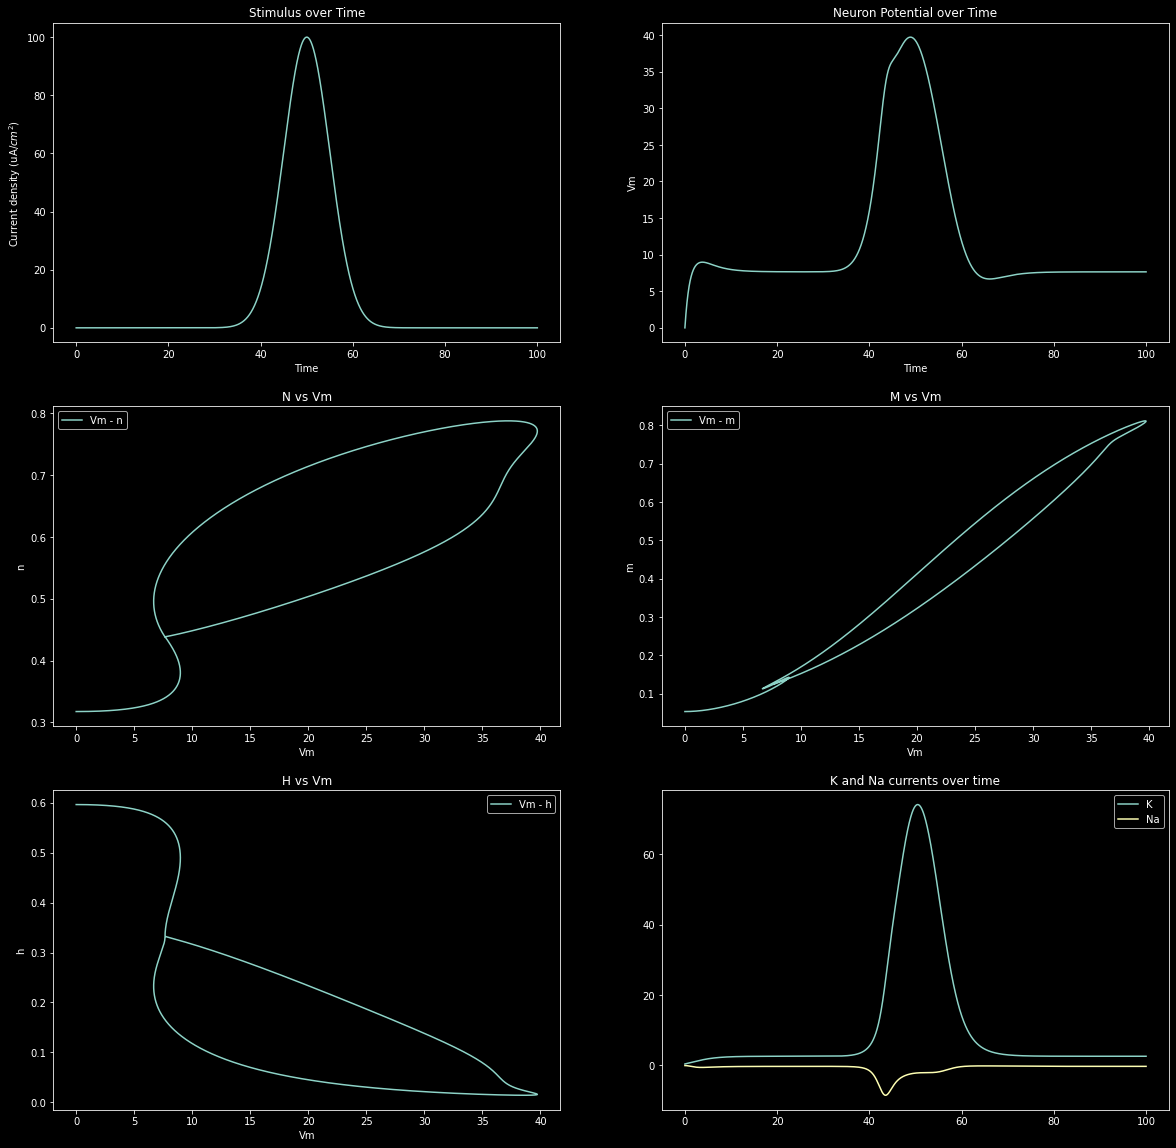

In [10]:
# Input stimulus
Idv = [I_gaussian(t) for t in t]

# Plot neuron potential over time
fig, ax = plt.subplots(3,2,figsize=(20, 20))
ax = ax.reshape(-1)
ax[1].plot(t, results[:, 0])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Vm')
ax[1].set_title('Neuron Potential over Time')
# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

# Plot some trajectories
ax[2].plot(results[:, 0], results[:, 1], label='Vm - n')
ax[3].plot(results[:, 0], results[:, 2], label='Vm - m')
ax[4].plot(results[:, 0], results[:, 3], label='Vm - h')
ax[2].set_title('N vs Vm')
ax[2].set_xlabel('Vm')
ax[2].set_ylabel('n')
ax[2].legend()
ax[3].set_title('M vs Vm')
ax[3].set_xlabel('Vm')
ax[3].set_ylabel('m')
ax[3].legend()
ax[4].set_title('H vs Vm')
ax[4].set_xlabel('Vm')
ax[4].set_ylabel('h')
ax[4].legend()

# plot Ik and Ina over time
ax[5].plot(t, gK * np.power(results[:, 1], 4.0) * (results[:, 0] - VK), label='K')
ax[5].plot(t, gNa * np.power(results[:, 2], 3.0) * results[:, 3] * (results[:, 0] - VNa), label='Na')
# ax[5].plot(t, gL * (results[:, 0] - Vl), label='L') ## LEAK CURRENT PLOT
ax[5].set_title('K and Na currents over time')
ax[5].legend()

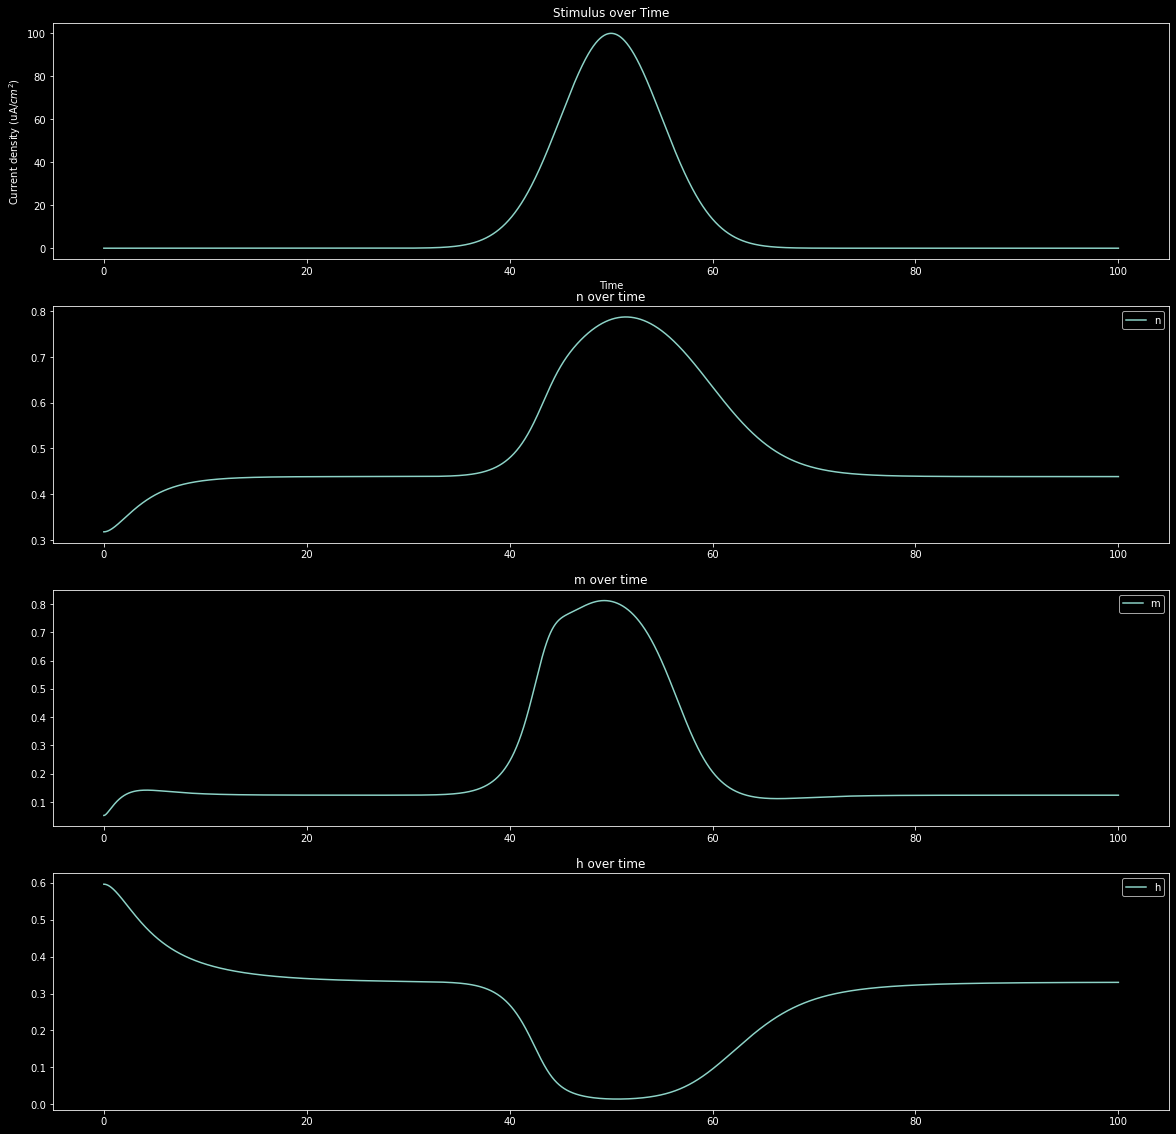

In [11]:
# Now plot n, m, and h over time
fig, ax = plt.subplots(4,1,figsize=(20, 20))

# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

ax[1].plot(t, results[:, 1], label='n')
ax[2].plot(t, results[:, 2], label='m')
ax[3].plot(t, results[:, 3], label='h')
ax[1].set_title('n over time')
ax[1].legend()
ax[2].set_title('m over time')
ax[2].legend()
ax[3].set_title('h over time')
ax[3].legend()

plt.show()

### Repeated square pulse

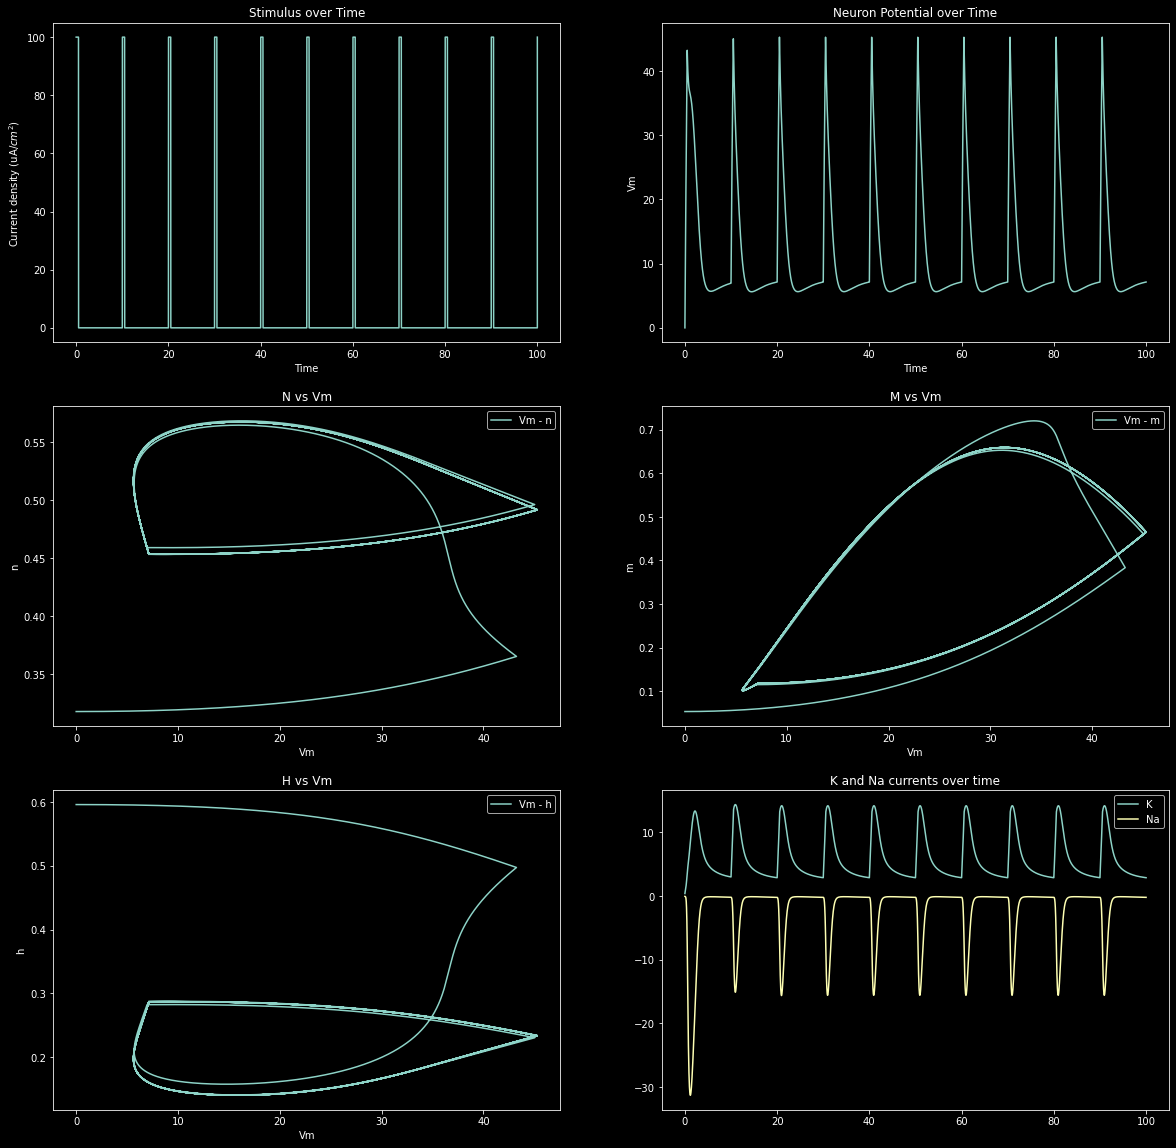

In [12]:
def I_square_repeated(t):
    # apply a pulse every 5 seconds
    return 100.0 * (t % 10.0 < 0.5)


t0 = 0
t1 = 100
t = np.linspace(t0, t1, 100000)
    
def derivatives(y, t0):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]

    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)

    # dVm/dt
    dy[0] = (I_square_repeated(t0) / C) - (((gK / C) * np.power(n, 4.0)) 
                        * (Vm - VK)) - (((gNa / C) * np.power(m, 3.0) * h) 
                        * (Vm - VNa)) - ((gL / C) * (Vm - Vl))
    
    return dy

# Solve ODE system
state = np.array([0.0, n_inf(), m_inf(), h_inf()])
results = odeint(derivatives, state, t)

# Input stimulus
Idv = [I_square_repeated(t) for t in t]

# Plot neuron potential over time
fig, ax = plt.subplots(3,2,figsize=(20, 20))
ax = ax.reshape(-1)
ax[1].plot(t, results[:, 0])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Vm')
ax[1].set_title('Neuron Potential over Time')
# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

# Plot some trajectories
ax[2].plot(results[:, 0], results[:, 1], label='Vm - n')
ax[3].plot(results[:, 0], results[:, 2], label='Vm - m')
ax[4].plot(results[:, 0], results[:, 3], label='Vm - h')
ax[2].set_title('N vs Vm')
ax[2].set_xlabel('Vm')
ax[2].set_ylabel('n')
ax[2].legend()
ax[3].set_title('M vs Vm')
ax[3].set_xlabel('Vm')
ax[3].set_ylabel('m')
ax[3].legend()
ax[4].set_title('H vs Vm')
ax[4].set_xlabel('Vm')
ax[4].set_ylabel('h')
ax[4].legend()

# plot Ik and Ina over time
ax[5].plot(t, gK * np.power(results[:, 1], 4.0) * (results[:, 0] - VK), label='K')
ax[5].plot(t, gNa * np.power(results[:, 2], 3.0) * results[:, 3] * (results[:, 0] - VNa), label='Na')
# ax[5].plot(t, gL * (results[:, 0] - Vl), label='L') ## LEAK CURRENT PLOT
ax[5].set_title('K and Na currents over time')
ax[5].legend()

We see that when we repeat the same input over time, our activation parameters enter limit cycles.

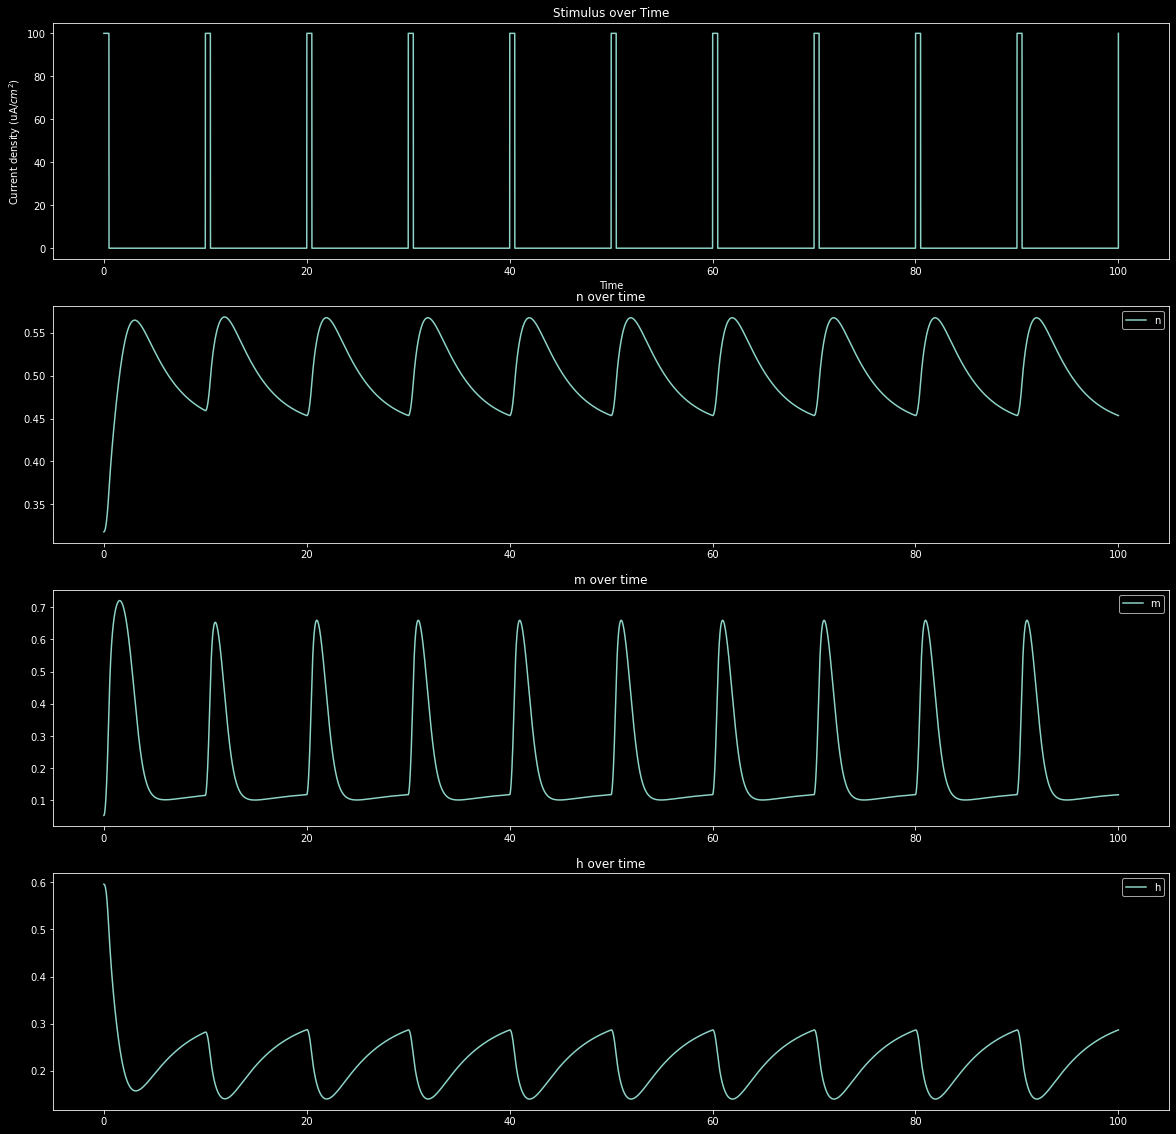

In [13]:
# Now plot n, m, and h over time
fig, ax = plt.subplots(4,1,figsize=(20, 20))

# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

ax[1].plot(t, results[:, 1], label='n')
ax[2].plot(t, results[:, 2], label='m')
ax[3].plot(t, results[:, 3], label='h')
ax[1].set_title('n over time')
ax[1].legend()
ax[2].set_title('m over time')
ax[2].legend()
ax[3].set_title('h over time')
ax[3].legend()

plt.show()

## Changing Membrane Capacitance
For any other parameter changes will we use the double square pulse as it is easy to read while we change other parameters.

First redefine the model to correspond to the double square pulse

In [14]:
t0 = 0
t1 = 100
t = np.linspace(t0, t1, 100000)

def derivatives(y, t0):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]

    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)

    # dVm/dt
    dy[0] = (I_double_square(t0) / C) - (((gK / C) * np.power(n, 4.0)) 
                        * (Vm - VK)) - (((gNa / C) * np.power(m, 3.0) * h) 
                        * (Vm - VNa)) - ((gL / C) * (Vm - Vl))
    
    return dy

Now we sweep over an array of different membrane capacitances and plot the Neuron potential over time for each one.

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.2037184692545D+02   r2 =  0.2540369189815D-08


/Users/pranavparakh/miniconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/var/folders/ff/g5jppyj915n4y1tccvvmwct00000gn/T/ipykernel_50858/2841207672.py:23: RuntimeWarning: overflow encountered in power
  dy[0] = (I_double_square(t0) / C) - (((gK / C) * np.power(n, 4.0))
/var/folders/ff/g5jppyj915n4y1tccvvmwct00000gn/T/ipykernel_50858/3828969789.py:29: RuntimeWarning: overflow encountered in exp
  return (0.01 * (10.0 - Vm)) / (np.exp((10.0 - Vm) / 10.0) - 1.0)
/var/folders/ff/g5jppyj915n4y1tccvvmwct00000gn/T/ipykernel_50858/3828969789.py:35: RuntimeWarning: overflow encountered in exp
  return (0.1 * (25.0 - Vm)) / (np.exp((25.0 - Vm) / 10) - 1.0)
/var/folders/ff/g5jppyj915n4y1tccvvmwct00000gn/T/ipykernel_50858/3828969789.py:44: RuntimeWarning: overflow encountered in exp
  return 1

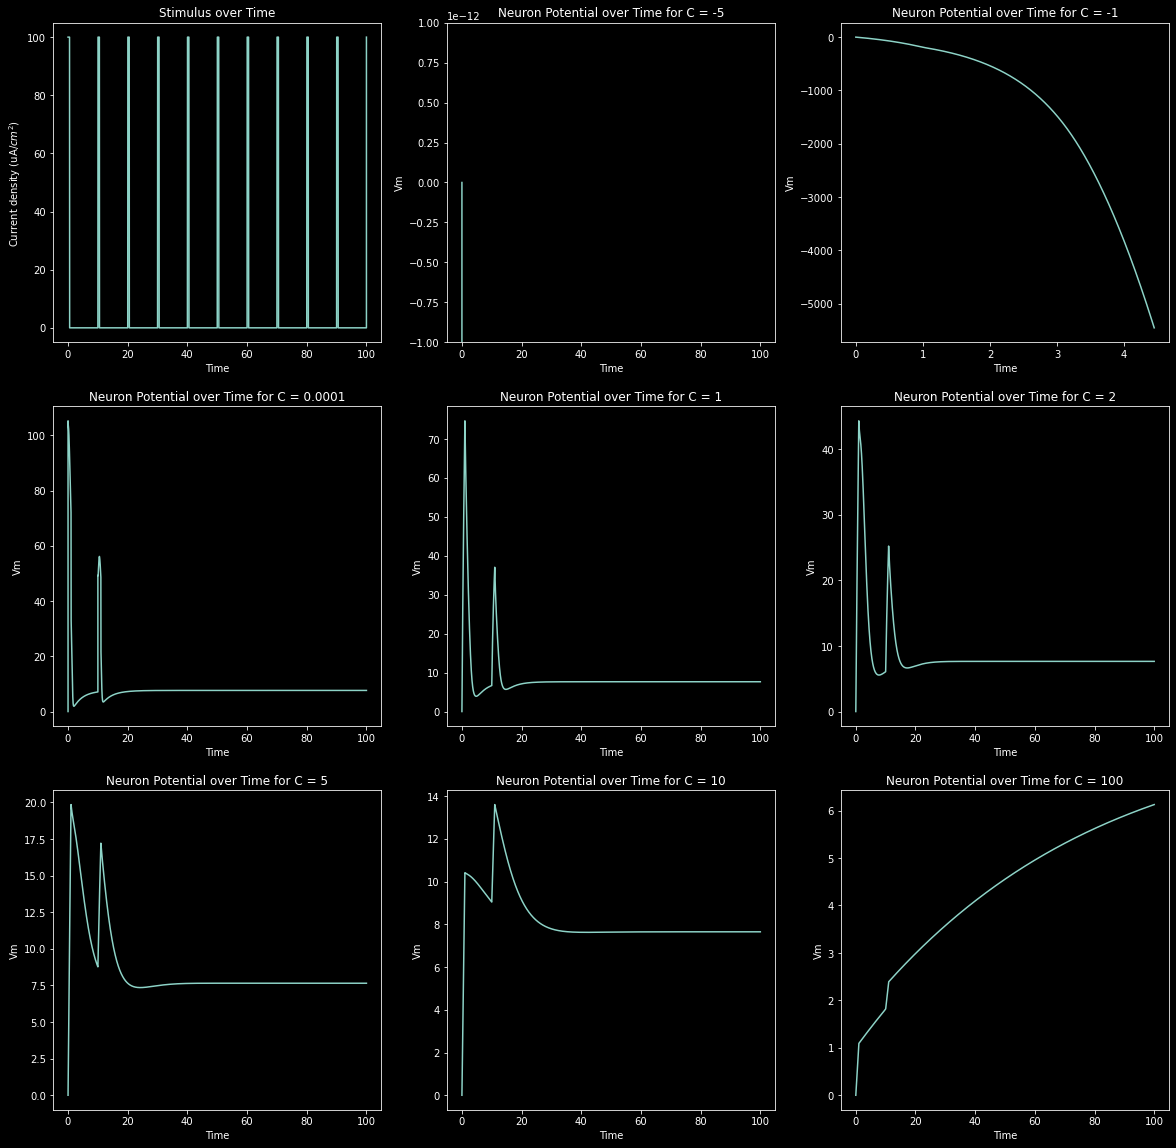

In [15]:
fig, ax = plt.subplots(3,3,figsize=(20, 20))
ax = ax.reshape(-1)

# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

Cs = [-5, -1,0.0001, 1,2, 5,10, 100]
for i, Curr in enumerate(Cs):
    # Membrane capacitance (uF/cm^2)
    C = Curr
        
    # Solve ODE system
    state = np.array([0.0, n_inf(), m_inf(), h_inf()])
    results = odeint(derivatives, state, t)

    # Input stimulus
    Idv = [I_double_square(t) for t in t]

    # Plot neuron potential over time
    ax = ax.reshape(-1)
    ax[i+1].plot(t, results[:, 0])
    ax[i+1].set_xlabel('Time')
    ax[i+1].set_ylabel('Vm')
    ax[i+1].set_title('Neuron Potential over Time for C = {}'.format(C))

# reset membrane capcaitance
C = 1

## Changing the Potassium Conductance

/var/folders/ff/g5jppyj915n4y1tccvvmwct00000gn/T/ipykernel_50858/3828969789.py:29: RuntimeWarning: overflow encountered in exp
  return (0.01 * (10.0 - Vm)) / (np.exp((10.0 - Vm) / 10.0) - 1.0)
/var/folders/ff/g5jppyj915n4y1tccvvmwct00000gn/T/ipykernel_50858/3828969789.py:32: RuntimeWarning: overflow encountered in exp
  return 0.125 * np.exp(-Vm / 80.0)
/var/folders/ff/g5jppyj915n4y1tccvvmwct00000gn/T/ipykernel_50858/3828969789.py:35: RuntimeWarning: overflow encountered in exp
  return (0.1 * (25.0 - Vm)) / (np.exp((25.0 - Vm) / 10) - 1.0)
/var/folders/ff/g5jppyj915n4y1tccvvmwct00000gn/T/ipykernel_50858/3828969789.py:38: RuntimeWarning: overflow encountered in exp
  return 4.0 * np.exp(-Vm / 18.0)
/var/folders/ff/g5jppyj915n4y1tccvvmwct00000gn/T/ipykernel_50858/3828969789.py:41: RuntimeWarning: overflow encountered in exp
  return 0.07 * np.exp(-Vm / 20.0)
/var/folders/ff/g5jppyj915n4y1tccvvmwct00000gn/T/ipykernel_50858/3828969789.py:44: RuntimeWarning: overflow encountered in exp
  

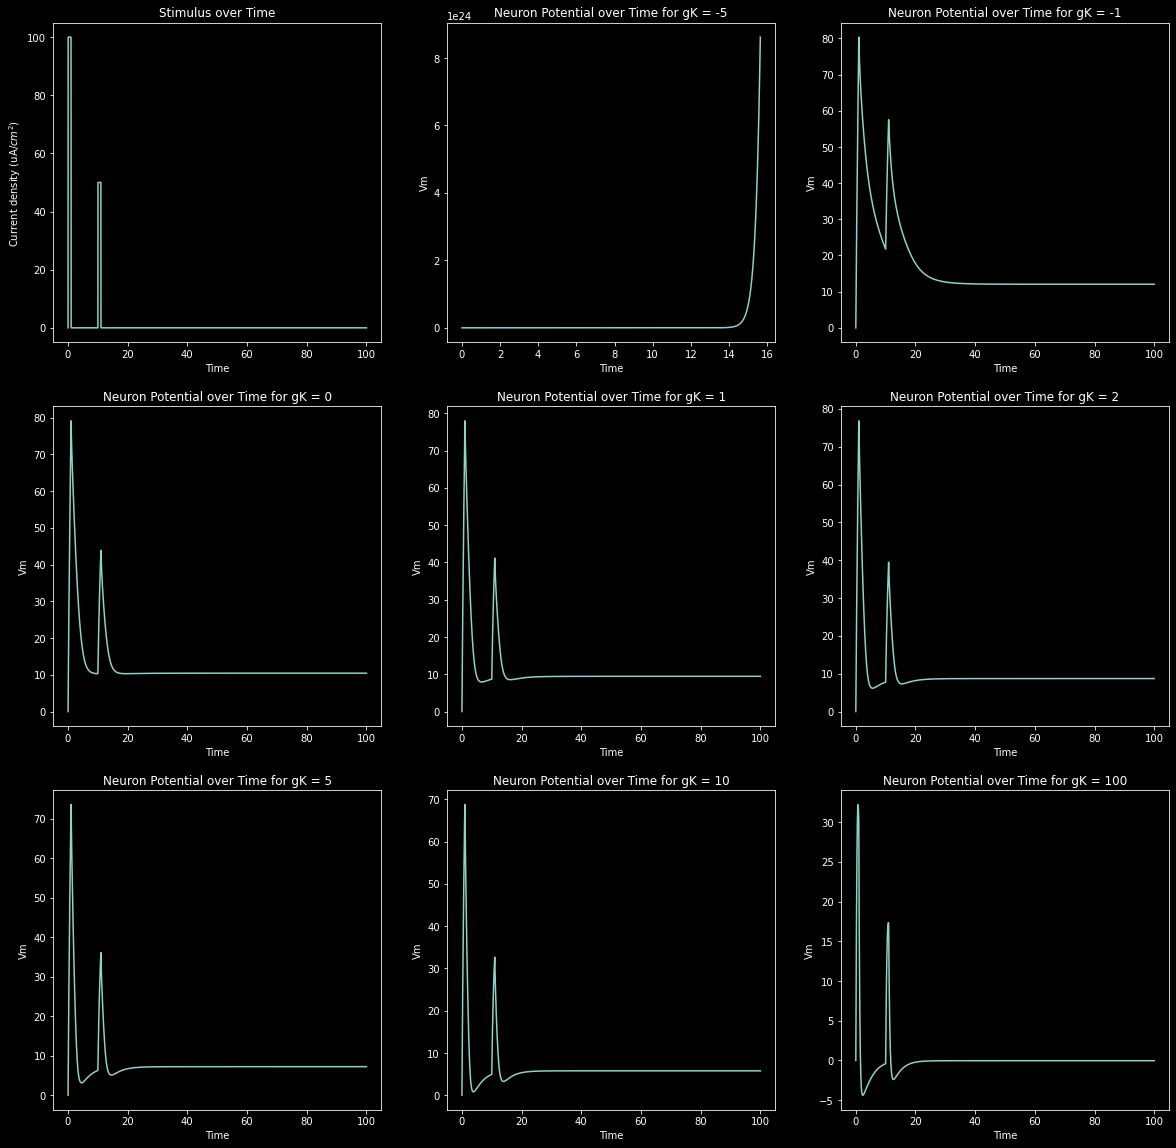

In [16]:
fig, ax = plt.subplots(3,3,figsize=(20, 20))
ax = ax.reshape(-1)

# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

gks = [-5, -1,0, 1,2, 5,10, 100]
for i, Curr in enumerate(gks):
    # Membrane capacitance (uF/cm^2)
    gK = Curr
        
    # Solve ODE system
    state = np.array([0.0, n_inf(), m_inf(), h_inf()])
    results = odeint(derivatives, state, t)

    # Input stimulus
    Idv = [I_double_square(t) for t in t]

    # Plot neuron potential over time
    ax = ax.reshape(-1)
    ax[i+1].plot(t, results[:, 0])
    ax[i+1].set_xlabel('Time')
    ax[i+1].set_ylabel('Vm')
    ax[i+1].set_title('Neuron Potential over Time for gK = {}'.format(gK))

# reset Potassium channel conductance (mS/cm^2)
gK = 4.0

Higher gK increases the refractory period, lowers the pulse peak. 

## Changing the Sodium Conductance

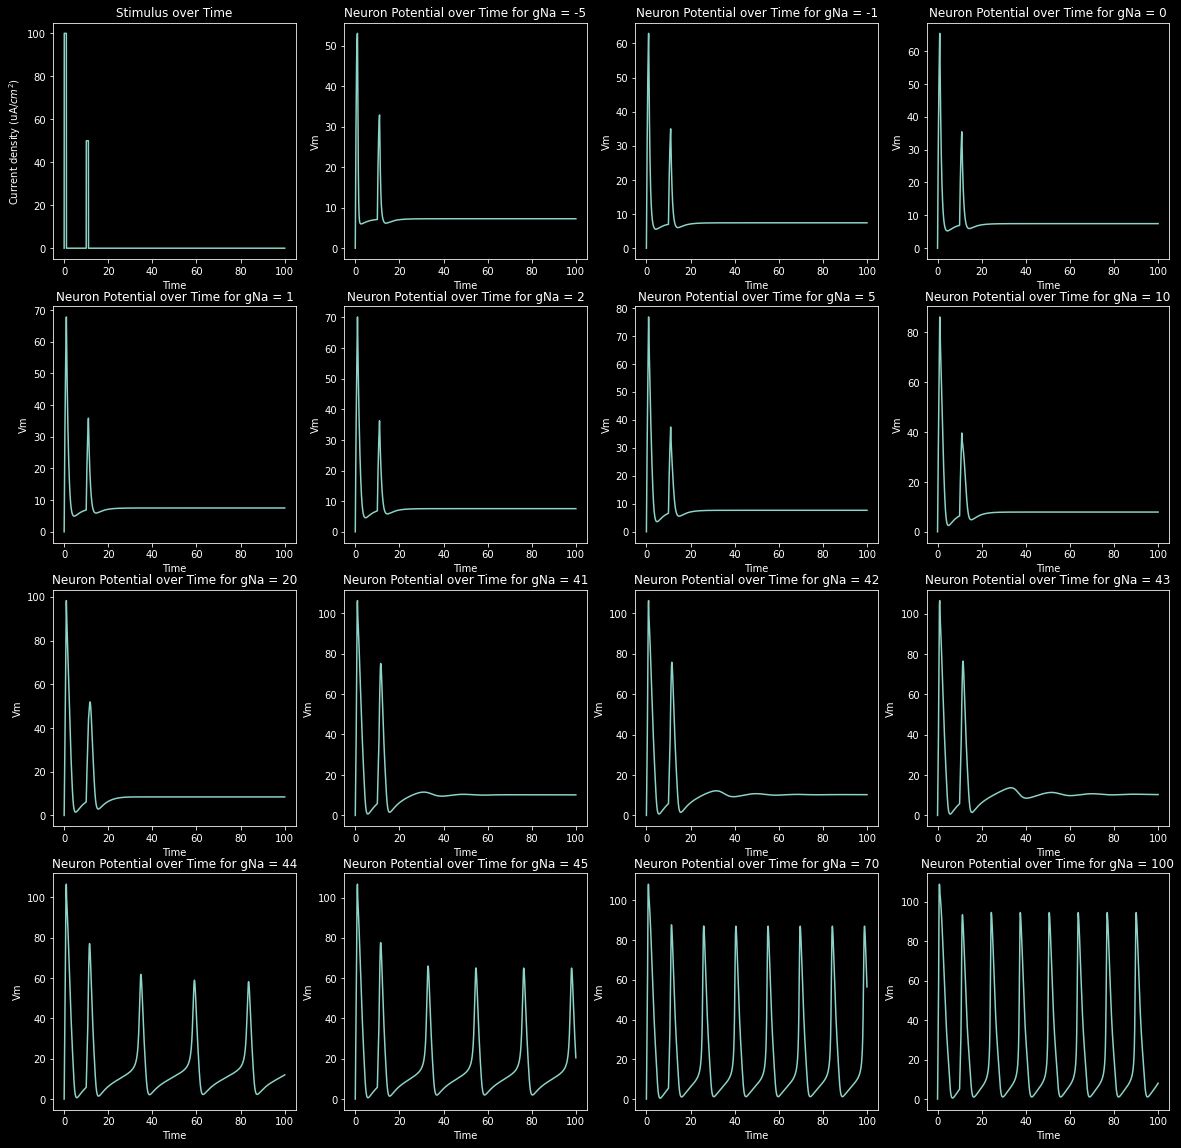

In [25]:
fig, ax = plt.subplots(4,4,figsize=(20, 20))
ax = ax.reshape(-1)

# Plotting the stimulus over time
ax[0].plot(t, Idv)
ax[0].set_ylabel(r'Current density (uA/$cm^2$)')
ax[0].set_xlabel('Time')
ax[0].set_title('Stimulus over Time')

gnas = [-5, -1,0, 1,2, 5,10, 20, 41,42, 43,44,45, 70, 100]
for i, Curr in enumerate(gnas):
    # Membrane capacitance (uF/cm^2)
    gNa = Curr
        
    # Solve ODE system
    state = np.array([0.0, n_inf(), m_inf(), h_inf()])
    results = odeint(derivatives, state, t)

    # Input stimulus
    Idv = [I_double_square(t) for t in t]

    # Plot neuron potential over time
    ax = ax.reshape(-1)
    ax[i+1].plot(t, results[:, 0])
    ax[i+1].set_xlabel('Time')
    ax[i+1].set_ylabel('Vm')
    ax[i+1].set_title('Neuron Potential over Time for gNa = {}'.format(gNa))

# reset sodium channel conductance (mS/cm^2)
gNa = 4.0

Interesting behaviour between 41 and 45. When the sodium conductance is high enough, the membrane potential doesnt die out quickly. Instead, it becomes periodic. What does this mean?

### References:
Problem set 5 implementation  
https://www.bonaccorso.eu/2017/08/19/hodgkin-huxley-spiking-neuron-model-python/   